In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Create input map

In [3]:
from scripts.spatial_network.run_entropy_maximisation_orientation_map import get_orientation_map
from scripts.spatial_layout import SpatialLayout
from scripts.interneuron_placement import plot_neural_sheet

In [4]:
sheet_length = 450
random = 4
long_half = 150
short_half = 30



In [5]:
input_map  = get_orientation_map(200, random, sheet_length, 450, data_folder="../data/")
spatial_layout = SpatialLayout(input_map, 900, 100, long_half, short_half, sheet_length )

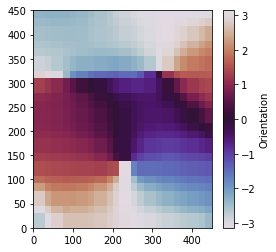

In [6]:
plot_neural_sheet(spatial_layout.ex_positions, spatial_layout.ex_tunings)

## Create interneuron axon

In [7]:
from scripts.interneuron_placement import Pickle, get_excitatory_phases_in_inhibitory_axon

In [8]:
from scripts.spatial_layout import get_entropy

In [9]:
ex_idx = 465

In [10]:
pos_x = spatial_layout.ex_positions[ex_idx][0]
pos_y = spatial_layout.ex_positions[ex_idx][1]

In [11]:
equivalent_radius = np.sqrt(long_half*short_half)
circular_axon = Pickle(pos_x, pos_y, equivalent_radius, equivalent_radius, 0)

In [12]:
neuron_positions = spatial_layout.ex_positions
neuron_tunings = spatial_layout.ex_tunings

In [13]:
number_of_phases = 8
phases = np.linspace(-np.pi/2, np.pi/2, number_of_phases, endpoint=False)

In [14]:
number_of_bins = 10
tuning_bins = np.linspace(-np.pi, np.pi, number_of_bins+1)
tunings = []
entropies = []
for phase in phases:
    axonal_cloud = Pickle(pos_x, pos_y, long_half, short_half, phase)
    tunings.append(get_excitatory_phases_in_inhibitory_axon(neuron_positions, neuron_tunings, axonal_cloud))
    entropies.append(get_entropy(axonal_cloud, neuron_positions, neuron_tunings, tuning_bins))

In [15]:
circular_entropy = get_entropy(circular_axon, neuron_positions, neuron_tunings, tuning_bins)

In [16]:
max_entropy = max(entropies)
max_phase = phases[np.argmax(entropies)]

In [17]:
circular_tuning = get_excitatory_phases_in_inhibitory_axon(neuron_positions, neuron_tunings, circular_axon)

Text(0.5, 0, 'Orientation')

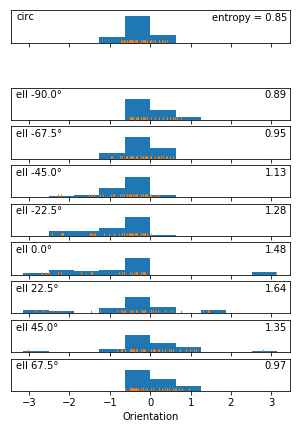

In [29]:
fig, axes = plt.subplots(number_of_phases+2, 1, sharex=True, sharey = True, figsize=(5,7))

axes[0].hist(circular_tuning, bins=10, range=(-np.pi, np.pi))
axes[0].plot(circular_tuning,  np.zeros((len(circular_tuning),)), '|')
axes[0].text(0.02, 0.95, 'circ', transform=axes[0].transAxes,  va='top', ha='left')
axes[0].text(0.99, 0.93, 'entropy = {:.2f}'.format(circular_entropy), transform=axes[0].transAxes, va='top', ha='right')

for phase, tuning, entropy, ax in zip(phases, tunings, entropies, axes[2:]):
    ax.hist(tuning, bins=10, range= (-np.pi, np.pi))
    ax.plot(tuning, np.zeros((len(tuning),)), '|')
    ax.text(0.02, 0.93, 'ell {:.1f}°'.format(phase/np.pi*180), transform=ax.transAxes, va='top', ha='left')
    ax.text(0.99, 0.93, '{:.2f}'.format(entropy), transform=ax.transAxes, va='top', ha='right')

axes[1].axis('off')
for ax in axes:
    ax.set_ylim(0,50)
    ax.yaxis.set_ticks([])
axes[-1].set_xlabel("Orientation")


In [30]:
fig.savefig("../figures/evolve_spatial_layout/select_max_entropy_orientation_hist.png", dpi=300)

In [20]:
axonal_cloud = Pickle(pos_x, pos_y, long_half, short_half, max_phase)

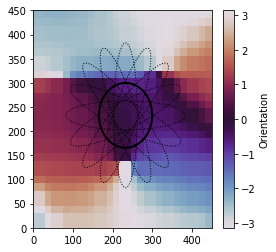

In [27]:
plot_neural_sheet(spatial_layout.ex_positions, spatial_layout.ex_tunings)
ax = plt.gca()
for phase in phases:
    ell = Pickle(pos_x, pos_y, long_half, short_half, phase).get_ellipse()
    ell.set_linestyle("dotted")
    ax.add_artist(ell)
circ = circular_axon.get_ellipse()
circ.set_linewidth(2)
ax.add_artist(circ)
plt.gcf().savefig("../figures/evolve_spatial_layout/select_max_entropy_orientation_layout_all_orient.png", dpi=300)

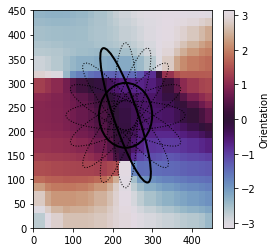

In [28]:
plot_neural_sheet(spatial_layout.ex_positions, spatial_layout.ex_tunings)
ax = plt.gca()
for phase in phases:
    ell = Pickle(pos_x, pos_y, long_half, short_half, phase).get_ellipse()
    ell.set_linestyle("dotted")
    ax.add_artist(ell)
max_ell = Pickle(pos_x, pos_y, long_half, short_half, max_phase).get_ellipse()
max_ell.set_linewidth(2)
ax.add_artist(max_ell)
circ = circular_axon.get_ellipse()
circ.set_linewidth(2)
ax.add_artist(circ)


plt.gcf().savefig("../figures/evolve_spatial_layout/select_max_entropy_orientation_layout_max_orient.png", dpi=300)

How to determine clustering and cluster sizes? https://stats.stackexchange.com/questions/40454/determine-different-clusters-of-1d-data-from-database

* we would be tempted to look for orientations that provide cluster with distinct orientation preferences, but the jumps are quite big in the orientation map which would mean that close by orientations do not compete
* circles and ellipsoids seem similar, in the uniform case they both cover all tunings, however sparsely, whereas for long correlation lengths circular axons have to deal with the position, they are either close to a switch or within a patch, ellipsoids can slightly compensate for this by their orientation
* maybe the most interesting would really be to try out brute force, what the optimal tuning could be for an ellipsoid arrangement and then look at their orientations...